# K Nearest Neighbor
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using K-nearest Neighbor to classify the data points on the target ("Outcome" of the stop and search).

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## Cleaning the Data set

In [21]:
data = pd.read_csv("data.csv")

# data = data.dropna()
data = util.data_cleaner(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values


In [22]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split data into train and test

In [ ]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

In [ ]:
## Evaluate K Nearest Neighbor

In [ ]:
print(f"Training Score: {knn.score(X_train, y_train)}")
print(f"Testig Score: {knn.score(X_test, y_test)}")
print("\n Confusion Matrix")
y_predictions = knn.predict(X_test)
util.confusion_plot(y_test=y_test, y_predictions=y_predictions)

In [ ]:
## Split target into "Police Action" (1) and "No Action" (0)

I will try to repeat the above process, but instead of the target being split into eight classes, I split it into two: either there was police action after the stop and search, or there wasn't.

In [ ]:
#Replace all values in Outcome column, with 0 if "Nothing found - no further action", else 1.
# Reference for dictionary idea to replace values: https://stackoverflow.com/questions/17114904/python-pandas-replacing-strings-in-dataframe-with-numbers
outcome_splitter = {
    "Nothing found - no further action": 0, 
    "Article found - Detailed outcome unavailable": 1, 
    "Local resolution": 1,
    "Offender cautioned": 1,
    "Offender given drugs possession warning": 1,
    "Offender given penalty notice": 1,
    "Suspect arrested": 1,
    "Suspect summonsed to court": 1
    }
data_binary = data.applymap(lambda s: outcome_splitter.get(s) if s in outcome_splitter else s)
data_binary.head()

In [ ]:
data_binary_encoded, encoders_binary = util.data_encoder(data_binary)

print(encoders_binary)
data_binary_encoded.head()

In [ ]:
# Split into features and target
target_binary = data_binary_encoded["Outcome"]
features_binary = data_binary_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(features_binary, target_binary, test_size=0.2, random_state=10)

In [ ]:
knn_binary = KNeighborsClassifier()
knn_binary.fit(X_train_binary, y_train_binary) 
print(f"Train (Binary) score: {knn_binary.score(X_train_binary, y_train_binary)}")
print(f"Test (Binary) score: {knn_binary.score(X_test_binary, y_test_binary)}")
print(f"\n Confusion matrix")

y_predictions_binary = knn_binary.predict(X_test_binary)
util.confusion_plot(y_test=y_test_binary, y_predictions=y_predictions_binary, target_classes=["No Action", "Action"])


Still, the model is heavily biased towards predicting no-action after a stop and search.

Let's compare the ratio of no-action to action in our y_train and y_test... perhaps our training data doesn't capture this ratio well

In [ ]:
#Reference for Pie Chart: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
_, frequencies_predict = np.unique(y_predictions_binary, return_counts=True)
_, frequencies_test = np.unique(y_test_binary, return_counts=True)

labels = ["No Action", "Action"]

fig1, ax1 = plt.subplots()
ax1.pie(frequencies_predict, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of No Police Action, to Action, in Training Set")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(frequencies_test, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of No Police Action, to Action, in Testing Set")
plt.show()

As seen above, there is a signfiicant mismatch between the number of 0s and 1s when comparing the test set vs the training set. Perhaps K Cross Validation will be better for train/test splitting.

## Training Using K-Fold Cross Validation

In [ ]:

#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_binary_k, X_test_binary_k, y_train_binary_k, y_test_binary_k = train_test_split(features_binary, target_binary, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [X_train_binary_k, y_train_binary_k]
k_fold_binary_data = pd.concat(frames, axis=1)

#K-cross validation on k_fold_binary_data 
knn_kfold = KNeighborsClassifier()
util.k_fold_train(model=knn_kfold, data=k_fold_binary_data)

As you can see, performance is better when splitting using k-fold. Also significantly less difference between training and testing scores, implying less overfitting.

Let's plot a confusion matrix, using the testing data set above. Notice, this is data that has not been used to train the model using K cross valdiation.

In [ ]:
y_predict_binary_k = knn_kfold.predict(X_test_binary_k)
util.confusion_plot(y_test=y_test_binary_k, y_predictions=y_predict_binary_k, target_classes=[0, 1])

Less false negatives, although still signficant bias to predicting no police action after stop and search.

## K-fold with all target classes

We repeat the above process, but using all target categories for the sake of completion.

In [ ]:
#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(features, target, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames_2 = [X_train_k, y_train_k]
k_fold_data = pd.concat(frames_2, axis=1)

#K-cross validation on k_fold_binary_data 
knn_kfold_all_classes = KNeighborsClassifier()
util.k_fold_train(model=knn_kfold_all_classes, data=k_fold_data)

In [ ]:
y_predict_k_a = knn_kfold_all_classes.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k_a)

The model pefroms better than without k-fold cross validation, however is once again, still clearly biased towards predicting no police action following from a search.

# Using SMOTE

We use SMOTE to even out the unbalanced dataset

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


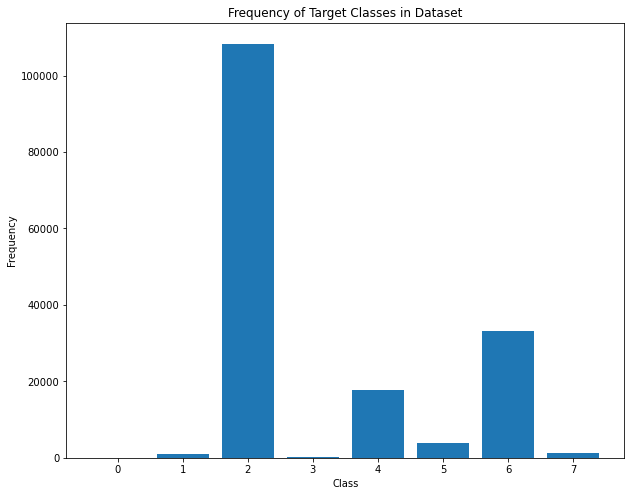

In [23]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

In [24]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target, test_size=0.2, random_state=10)

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


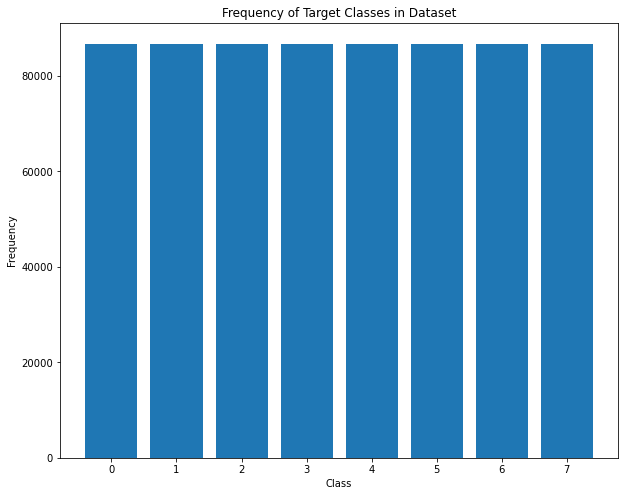

In [25]:
X_smote, y_smote = usm.smote_data(X_train2, y_train2)
usm.display_frequencies(y_smote)

In [26]:
knn = KNeighborsClassifier()
knn.fit(X_smote, y_smote)

KNeighborsClassifier()

Training Score: 0.5561122849381226
Testig Score: 0.23814554344873382

 Confusion Matrix


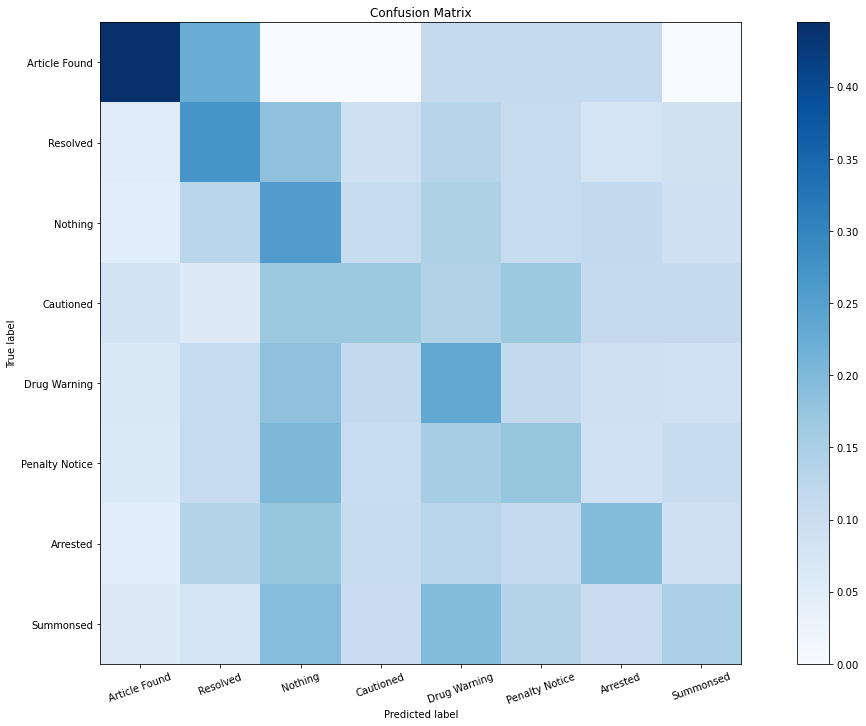

In [27]:
print(f"Training Score: {knn.score(X_train2, y_train2)}")
print(f"Testig Score: {knn.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = knn.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

# Using Biased SMOTE
We over sample minority classes, but not to an extent that equalizes them to the majority class


Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


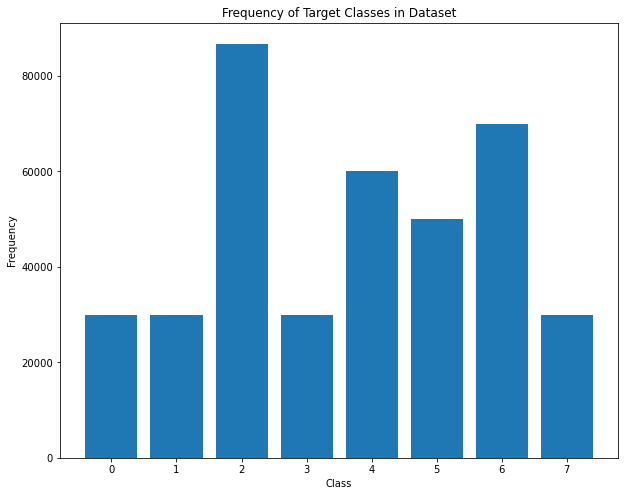

In [28]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train2, y_train2, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_smote, y_smote)

KNeighborsClassifier()

Training Score: 0.6325611228493813
Testig Score: 0.33841417403640095

 Confusion Matrix


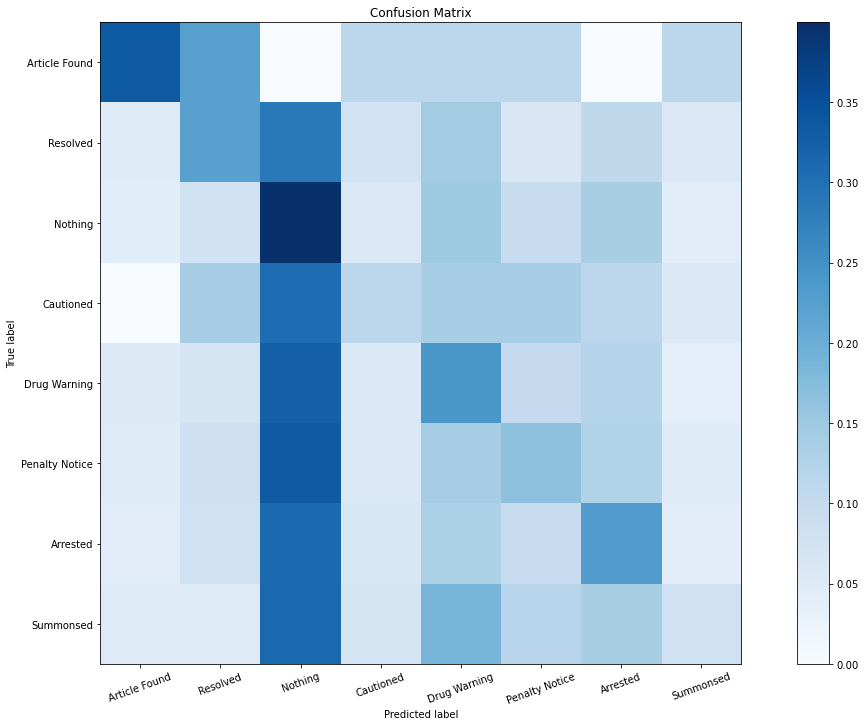

In [30]:
print(f"Training Score: {knn.score(X_train2, y_train2)}")
print(f"Testig Score: {knn.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = knn.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)